In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os,pickle
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
os.chdir('/content/gdrive/My Drive/Quora_question')

#[1] TFIDF Weighted GLOVE

In [ ]:
#loading tfidf weighted glove
X_train = pd.read_csv('data/train_data.csv')
X_test = pd.read_csv('data/test_data.csv')
y_train = pd.read_csv('data/train_y.csv')
y_test = pd.read_csv('data/test_y.csv')
X_train = X_train.drop(columns=['q1_glove','q2_glove'])
X_test = X_test.drop(columns=['q1_glove','q2_glove'])
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(70000, 218)
(30000, 218)
(70000, 1)
(30000, 1)


In [ ]:
X_train.head(3)

,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,g_0,g_1,g_2,g_3,g_4,g_5,g_6,g_7,g_8,g_9,g_10,g_11,g_12,g_13,...,g_152,g_153,g_154,g_155,g_156,g_157,g_158,g_159,g_160,g_161,g_162,g_163,g_164,g_165,g_166,g_167,g_168,g_169,g_170,g_171,g_172,g_173,g_174,g_175,g_176,g_177,g_178,g_179,g_180,g_181,g_182,g_183,g_184,g_185,g_186,g_187,g_188,g_189,g_190,g_191
0,1,1,54,56,10,10,6.0,19.0,0.315789,2,0,0.749981,0.749981,0.599988,0.499992,0.599994,0.599994,0.0,1.0,0.0,10.0,87,74,80,80,0.672727,8.620377,-1.614727,-2.521583,-1.531998,2.092236,0.767564,5.339287,3.058473,10.082106,11.054510,-3.507912,-3.432895,-0.067182,-10.681097,...,10.089836,3.936834,-5.538895,5.563270,8.331845,-7.516664,4.947571,0.551604,2.226217,-5.257148,4.661740,-4.827672,-2.469894,-2.716766,-4.011982,-1.669388,2.131926,-1.406734,-1.637095,0.843460,9.596346,-8.810573,-0.189235,0.185671,-0.870233,-8.293420,-5.647267,5.515711,3.732003,-7.587928,-2.701354,2.716441,-0.510052,6.447781,-2.949746,-0.962468,2.531881,6.010862,1.527958,1.486945
1,1,1,56,45,9,8,8.0,17.0,0.470588,2,0,0.999950,0.666644,0.999983,0.999983,0.999988,0.888879,1.0,1.0,1.0,8.5,100,89,89,89,0.826087,-0.976643,-2.725152,2.448420,-6.019244,10.633596,-0.612285,2.808925,2.506091,3.439625,2.748850,-2.935436,5.436929,-2.523156,6.865408,...,4.418640,3.693307,1.570967,5.141033,10.051354,2.914478,3.694912,1.172728,2.013224,-3.563407,4.454383,-6.441067,2.158532,-0.239046,-6.496768,-3.577290,5.334235,0.750009,3.977217,-3.131306,6.806299,-5.550982,-5.664017,-4.400164,-1.581056,3.991659,1.210462,0.192518,3.626633,-2.551011,3.914964,0.328768,-2.454020,0.270393,-9.784351,-0.421203,2.982829,3.221098,-0.517070,7.156083
2,4,3,111,96,19,17,8.0,34.0,0.235294,7,1,0.444440,0.444440,0.571420,0.444440,0.470585,0.421050,0.0,0.0,2.0,18.0,65,60,27,43,0.216495,1.364633,-0.612766,-0.917767,4.277427,10.759067,7.220730,2.623590,2.577329,10.591618,13.758568,-0.620000,2.298428,-1.027227,-4.799027,...,5.248811,7.349653,-5.088327,5.053706,7.250805,0.519352,1.788629,0.233627,7.627815,-0.252892,11.181622,-7.246195,-1.489986,3.130861,-1.450135,-1.716376,7.907278,0.924074,-4.189400,-1.036867,6.969816,-9.251938,-0.795776,-0.299615,1.590454,-3.170906,-1.801627,0.208262,5.480814,-4.081170,-2.047053,-4.732654,-0.826601,6.169578,0.445108,-2.095889,4.520428,-1.048259,0.624426,6.458432


In [ ]:
X_test.head(3)

,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,g_0,g_1,g_2,g_3,g_4,g_5,g_6,g_7,g_8,g_9,g_10,g_11,g_12,g_13,...,g_152,g_153,g_154,g_155,g_156,g_157,g_158,g_159,g_160,g_161,g_162,g_163,g_164,g_165,g_166,g_167,g_168,g_169,g_170,g_171,g_172,g_173,g_174,g_175,g_176,g_177,g_178,g_179,g_180,g_181,g_182,g_183,g_184,g_185,g_186,g_187,g_188,g_189,g_190,g_191
0,14,14,45,51,6,7,4.0,13.0,0.307692,28,0,0.749981,0.749981,0.499975,0.333322,0.666656,0.571420,1.0,0.0,1.0,6.5,87,79,83,87,0.608696,0.612278,-3.942651,-8.818967,-2.501753,15.810735,11.138597,0.387640,-1.177635,7.402584,8.513069,2.473229,-10.878558,1.026936,6.129054,...,-7.545232,9.440702,7.048005,2.317969,8.545069,-6.574237,4.553792,-3.352811,19.114544,-4.980732,7.898074,-6.348878,12.020767,0.444384,-3.353588,2.004786,4.434849,-5.041046,5.715216,2.353666,10.170400,-4.123979,-1.144980,-2.034350,-0.081597,-11.209025,0.535740,0.558793,6.037734,-12.116781,3.969435,-4.386923,5.229480,6.589633,-13.695223,-2.685117,8.354160,8.374036,-7.196234,19.219431
1,3,1,82,53,13,9,0.0,21.0,0.000000,4,2,0.399992,0.399992,0.000000,0.000000,0.222220,0.153845,0.0,0.0,4.0,11.0,60,59,42,55,0.277778,-5.683469,3.083360,1.681166,-5.201771,6.727090,-1.414133,-1.522692,-0.075468,-0.947463,5.226710,-0.478414,1.509829,-0.063908,-3.539158,...,9.807779,1.571908,-3.035435,3.513985,6.976508,-0.392624,-4.029492,2.376525,-2.970107,-1.070152,8.731825,-2.632239,0.196710,8.772021,-2.880338,0.069473,1.515940,-3.420026,-6.288407,-0.918903,3.008246,-2.611791,-0.394613,-0.040115,-0.865941,0.198538,0.408968,-0.428670,-0.204146,-0.570725,-2.151148,1.043688,1.686962,1.703929,-1.317777,-2.861869,1.587751,2.456052,-3.206597,6.237281
2,42,46,66,28,12,6,4.0,18.0,0.222222,88,4,0.999967,0.499992,0.333322,0.166664,0.666656,0.333331,1.0,0.0,6.0,9.0,88,46,50,89,0.655172,-0.324799,-2.121402,-4.809023,-2.579247,4.023664,-0.068430,6.418925,3.172831,6.591637,2.150353,0.382578,3.319465,2.568779,-6.292074,...,9.553576,1.552370,-2.679412,-0.008724,8.566373,-8.296816,-4.378370,-2.526224,-0.689918,-2.451400,-2.575501,5.584104,0.723447,3.256052,-4.436919,7.084064,5.341232,5.525335,-5.897781,-2.825213,6.039283,3.986308,0.960049,2.894634,0.042847,-1.321844,-4.584669,3.647700,-0.366333,-0.866130,-1.119629,-1.178872,0.693722,0.528563,2.404150,5.529877,-6.858145,8.659120,-0.890519,1.957024


In [ ]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    #[TN FP]
    #[FN TP]   
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #precision = true positive / predicted positive
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #recall = true positive/ actual positive
    #divide each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    # cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True,  fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

# Logistic Regression

For values of alpha =  1e-05 The log loss is: 0.40165158273973967
For values of alpha =  0.0001 The log loss is: 0.4097987561484816
For values of alpha =  0.001 The log loss is: 0.4145151296456632
For values of alpha =  0.01 The log loss is: 0.39427716888842734
For values of alpha =  0.1 The log loss is: 0.4205558307935418
For values of alpha =  1 The log loss is: 0.45518958942966337
For values of alpha =  10 The log loss is: 0.5061195162170091


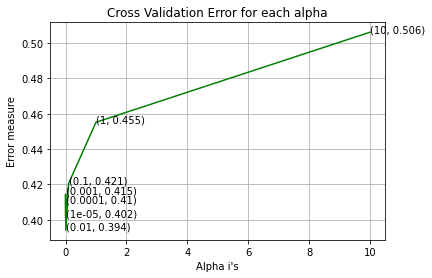

In [ ]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

For values of best alpha =  0.01 The train log loss is: 0.38510814521770803
For values of best alpha =  0.01 The test log loss is: 0.39427716888842734
Total number of data points : 30000


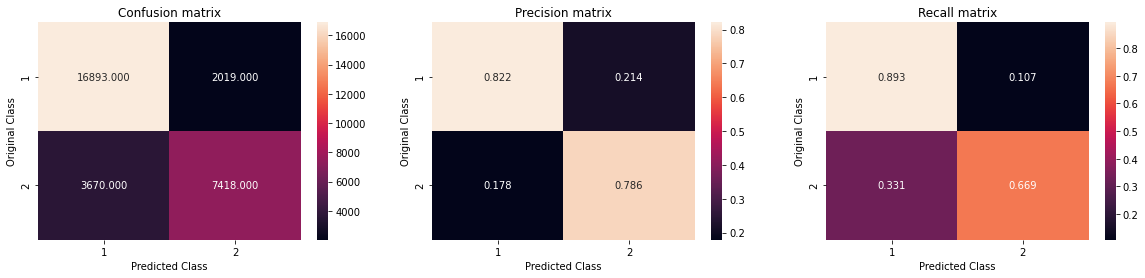

In [ ]:
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

Interpretation of precision matrix:

* Of all the points predicted as class1 17% belongs to class 2 and 82% is predicted correct as class1.

* Similarly of all points predicted as class2 78% belongs to class2 and 21% belongs to class1.

Recall matrix:
* Of all actual points belonging to class 1, 89.3% is precied as class 1 and rest 10.7% as class2.
* Similarly, Of all the actual points belonging to class 2, 31% is predicted as class 1 and 66.9% as class2.

## Linear SVM with hinge Loss

For values of alpha =  1e-05 The log loss is: 0.4013909147996854
For values of alpha =  0.0001 The log loss is: 0.4089492233295954
For values of alpha =  0.001 The log loss is: 0.4055115317016078
For values of alpha =  0.01 The log loss is: 0.39550174611595856
For values of alpha =  0.1 The log loss is: 0.417725401342702
For values of alpha =  1 The log loss is: 0.4426284228684692
For values of alpha =  10 The log loss is: 0.49218040185209827


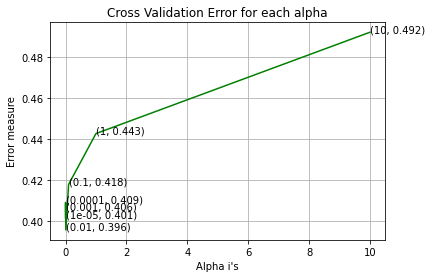

In [ ]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

For values of best alpha =  0.01 The train log loss is: 0.3876547800339339
For values of best alpha =  0.01 The test log loss is: 0.39550174611595856
Total number of data points : 30000


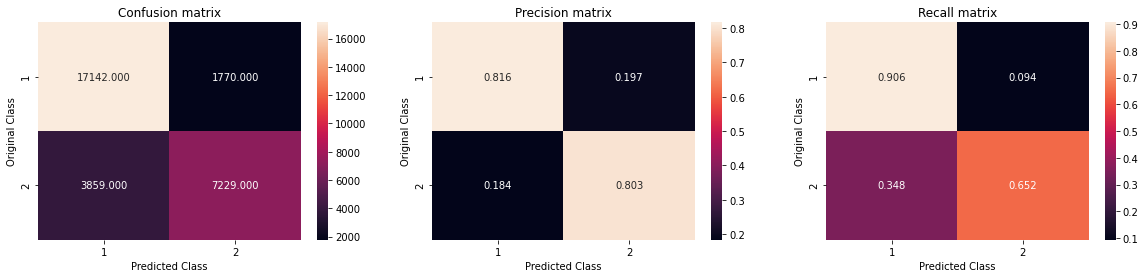

In [ ]:
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## XGBoost Classifier

In [ ]:

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

params = {
        'max_depth': [i for i in range(1,8,2)],
        'n_estimators' : [i*10 for i in range(1, 10)],
         'gamma': [0, 0.25, 0.5, 1.0],'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3]         
        }
xgboost_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss',n_jobs=-1)

xgb_search = RandomizedSearchCV(xgboost_model, param_distributions = params,n_iter=30,
                         scoring = 'neg_log_loss', n_jobs = -1,cv=3)

xgb_search.fit(X_train, y_train)

print("Best score : ",xgb_search.best_score_)
print("Best Parameters",xgb_search.best_params_)

Best score :  -0.31533046342326315
Best Parameters {'n_estimators': 90, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0}


Log loss for tfidf train data :  0.18352535336611045
Log loss for tfidf test data :  0.3216499608813009


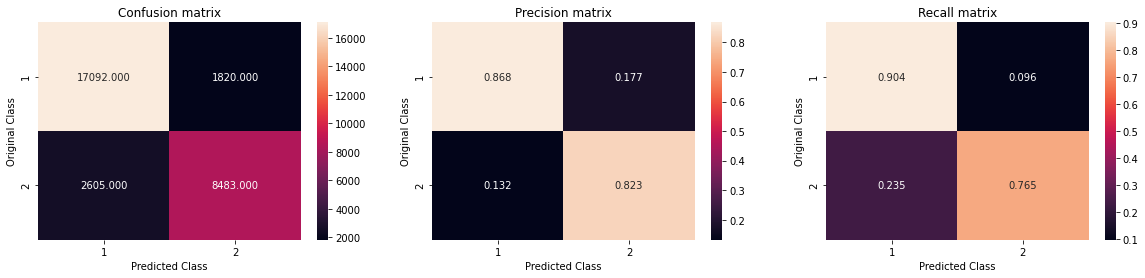

In [ ]:
clf = xgb.XGBClassifier(**xgb_search.best_params_,objective='binary:logistic', eval_metric='logloss',n_jobs=-1)
clf.fit(X_train, y_train)   

#log loss uses a exact prob score 
cal_clf = CalibratedClassifierCV(clf, method="sigmoid")
cal_clf.fit(X_train, y_train)

predict_y = cal_clf.predict_proba(X_train)

print("Log loss for tfidf train data : ",log_loss(y_train, predict_y,  eps=1e-15))
predict_y = cal_clf.predict_proba(X_test)

print("Log loss for tfidf test data : ",log_loss(y_test, predict_y,  eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
plot_confusion_matrix(y_test, predicted_y)

#[2] TFIDF Features

In [ ]:
#tfidf-w2v
X_train = pickle.load(open("data/tfidf_X_tr","rb"))
X_test = pickle.load(open("data/tfidf_X_test","rb"))
y_test = pd.read_csv('data/test_y.csv')
y_train = pd.read_csv('data/train_y.csv')

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(70000, 40000)
(30000, 40000)
(70000, 1)
(30000, 1)


## Logistic Regression

For values of alpha =  1e-05 The log loss is: 0.5394207245766669
For values of alpha =  0.0001 The log loss is: 0.543951104454476
For values of alpha =  0.001 The log loss is: 0.5717219674143557
For values of alpha =  0.01 The log loss is: 0.5963950767969237
For values of alpha =  0.1 The log loss is: 0.6433334574047959
For values of alpha =  1 The log loss is: 0.6511035183412025
For values of alpha =  10 The log loss is: 0.6518019256424172


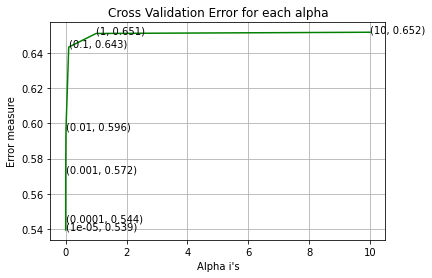

In [ ]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

For values of best alpha =  1e-05 The train log loss is: 0.4362009071577383
For values of best alpha =  1e-05 The test log loss is: 0.5394207245766669
Total number of data points : 30000


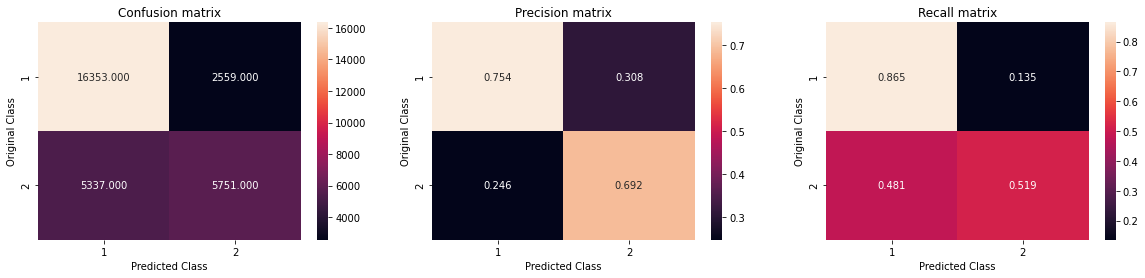

In [ ]:
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## Linear SVM with hinge Loss

For values of alpha =  1e-05 The log loss is: 0.5524954614855542
For values of alpha =  0.0001 The log loss is: 0.5443965550252065
For values of alpha =  0.001 The log loss is: 0.5765725926658049
For values of alpha =  0.01 The log loss is: 0.5852451402804573
For values of alpha =  0.1 The log loss is: 0.6518244656269191
For values of alpha =  1 The log loss is: 0.6518244656246968
For values of alpha =  10 The log loss is: 0.6518244656268375


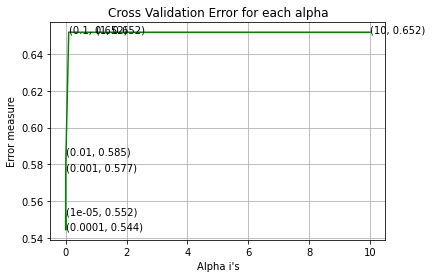

In [ ]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

For values of best alpha =  0.0001 The train log loss is: 0.48845546462164263
For values of best alpha =  0.0001 The test log loss is: 0.5443965550252065
Total number of data points : 30000


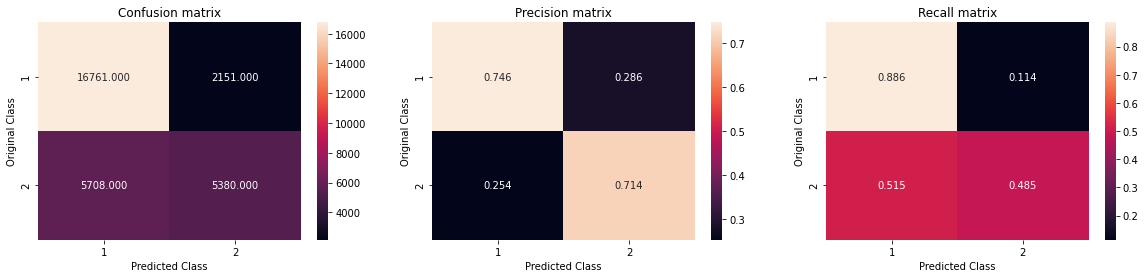

In [ ]:
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## XGBoost

In [ ]:

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

params = {
        'max_depth': [i for i in range(1,8,2)],
        'n_estimators' : [i*10 for i in range(1, 10)],
         'gamma': [0, 0.25, 0.5, 1.0],'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3]         
        }
xgboost_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss',n_jobs=-1)

xgb_search = RandomizedSearchCV(xgboost_model, param_distributions = params,n_iter=30,
                         scoring = 'neg_log_loss', n_jobs = -1,cv=3)

xgb_search.fit(X_train, y_train)

print("Best score : ",xgb_search.best_score_)
print("Best Parameters",xgb_search.best_params_)

Best score :  -0.5267292976532817
Best Parameters {'n_estimators': 90, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0}


Log loss for tfidf train data :  0.457118723862266
Log loss for tfidf test data :  0.516786008483028


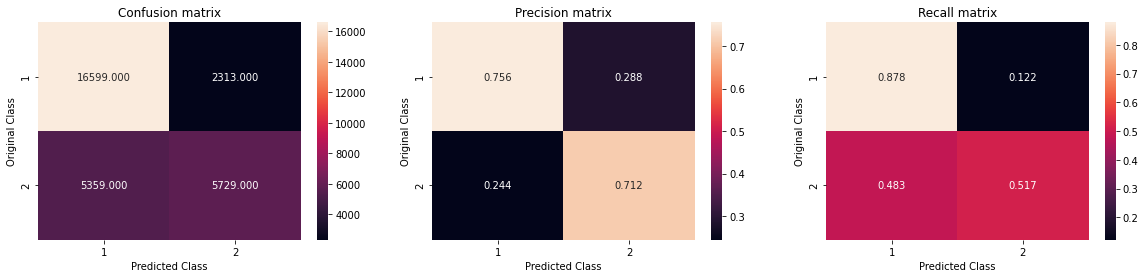

In [ ]:
clf = xgb.XGBClassifier(**xgb_search.best_params_,objective='binary:logistic', eval_metric='logloss',n_jobs=-1)
clf.fit(X_train, y_train)   

#log loss uses a exact prob score 
cal_clf = CalibratedClassifierCV(clf, method="sigmoid")
cal_clf.fit(X_train, y_train)

predict_y = cal_clf.predict_proba(X_train)

print("Log loss for tfidf train data : ",log_loss(y_train, predict_y,  eps=1e-15))
predict_y = cal_clf.predict_proba(X_test)

print("Log loss for tfidf test data : ",log_loss(y_test, predict_y,  eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
plot_confusion_matrix(y_test, predicted_y)

# Conclusion

In [21]:
from prettytable import PrettyTable
print("TF-IDF w2v")
x = PrettyTable()
x.field_names = ["ML Model", "Vectorizer", "Train log loss", "Test log loss"]

x.add_row(["Logistic Regression",'TF-IDF w2v', 0.385, 0.3942])
x.add_row(["Linear SVM", 'TF-IDF w2v', 0.387, 0.395])
x.add_row(["XGBoost", 'TF-IDF w2v', 0.183,0.321])
print(x)


print("\n TF-IDF vec")
x = PrettyTable()
x.field_names = ["ML Model", "Vectorizer", "Train log loss", "Test log loss"]

x.add_row(["Logistic Regression",'TF-IDF ', 0.436,0.539])
x.add_row(["Linear SVM", 'TF-IDF ',0.488,0.544 ])
x.add_row(["XGBoost", 'TF-IDF ', 0.457,0.516])
print(x)

TF-IDF w2v
+---------------------+------------+----------------+---------------+
|       ML Model      | Vectorizer | Train log loss | Test log loss |
+---------------------+------------+----------------+---------------+
| Logistic Regression | TF-IDF w2v |     0.385      |     0.3942    |
|      Linear SVM     | TF-IDF w2v |     0.387      |     0.395     |
|       XGBoost       | TF-IDF w2v |     0.183      |     0.321     |
+---------------------+------------+----------------+---------------+

 TF-IDF vec
+---------------------+------------+----------------+---------------+
|       ML Model      | Vectorizer | Train log loss | Test log loss |
+---------------------+------------+----------------+---------------+
| Logistic Regression |  TF-IDF    |     0.436      |     0.539     |
|      Linear SVM     |  TF-IDF    |     0.488      |     0.544     |
|       XGBoost       |  TF-IDF    |     0.457      |     0.516     |
+---------------------+------------+----------------+-------------